# Perform cross-validation to dig into the most promising hyperparameters# 

__author__: Andrew Bartnof

__copyright__: Copyright 2025, Rocky Mountain Institute

__credits__: Alex Engel, Andrew Bartnof

In [7]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import os

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, log_loss
from tqdm.notebook import tqdm
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [8]:
def np_cleaning(X):
    X = np.clip(X, a_min=-3, a_max=3)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X

In [9]:
data_dir = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker'
dir_working_model_b_training = os.path.join(data_dir, 'working_data/model_b/model_b_training')
dir_working_model_b_training

'/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_b/model_b_training'

In [10]:
fn_x = os.path.join(dir_working_model_b_training, 'x.parquet')
fn_y = os.path.join(dir_working_model_b_training, 'y.parquet')
fn_id = os.path.join(dir_working_model_b_training, 'id.parquet')

dir_hyperparameters = dir_working_model_b_training
fn_grid = os.path.join(dir_working_model_b_training, 'gb_ray_tune/model_b_ann_hp_search.csv')
fn_cv = os.path.join(dir_working_model_b_training, 'gb_ray_tune/model_b_ann_hp_search_2_cv.csv')

In [11]:
X = pd.read_parquet(fn_x)
Y = pd.read_parquet(fn_y)
ID = pd.read_parquet(fn_id)

In [12]:
rename_dict = {'config/num_trees':'num_trees', 'config/learning_rate':'learning_rate', 'config/min_data_in_leaf':'min_data_in_leaf', 'config/objective':'objective', 'config/early_stopping_round':'early_stopping_round'} #, 'config/metrics':'metrics'}

Grid = pd.read_csv(fn_grid, index_col='rank')
Grid = Grid.rename(columns=rename_dict)[list(rename_dict.values())]

# Create a dictionary: punch in the rank of the model we want to use, and get the parameters back, as a dictionary
param_dict = {i:Grid.loc[i].to_dict() for i in Grid.index}
param_dict[0]

{'num_trees': 289,
 'learning_rate': 0.0132879024075759,
 'min_data_in_leaf': 56,
 'objective': 'binary',
 'early_stopping_round': -1}

Each record_id_ferc1 is mapped to a number, 0:num_folds. 

This means that for any fold, we can say that any record_id_ferc1 that corresponds to that number is testing data, and all others are training data

In [ ]:
variables = [
    range(15),  # num hyperparameters to test
    range(5)  # number of folds in the ID table
]

metrics_list = []
for (hp_rank, fold) in tqdm(list(itertools.product(*variables))):

    # Split data into training, testing
    is_training_data_mask = (ID['fold'] != fold).values
    XTrain = X.loc[is_training_data_mask]
    XTest = X.loc[~is_training_data_mask]

    # Scale data
    standard_scaler = StandardScaler()
    standard_scaler.fit(XTrain)
    
    XTrain = standard_scaler.transform(XTrain)
    XTest  = standard_scaler.transform(XTest)
    
    XTrain = np_cleaning(XTrain)
    XTest  = np_cleaning(XTest)
    
    # Package in training and testing objects
    train_set = lgb.Dataset(XTrain, Y.loc[is_training_data_mask])
    YTest = Y.loc[~is_training_data_mask]

    # Fit the model, get probabilities (ie y_fit)
    mod_fit = lgb.train(params=param_dict[hp_rank], train_set=train_set)
    y_fit = mod_fit.predict(XTest)

    # Pull together y_fit along with the record_id_ferc1, which allows us to see which y_fit is the 
    # highest per record_id_ferc1
    Framework = ID[~is_training_data_mask].copy()
    Framework['y_true'] = YTest['is_match']
    Framework['y_fit'] = y_fit
    Framework = Framework[['record_id_ferc1', 'y_fit', 'y_true']]

    # groupwise best prediction, for each record_id_ferc1
    Framework['groupwise_max_y_fit'] = Framework.groupby('record_id_ferc1')['y_fit'].transform('max')
    Framework['y_fit_adj'] = Framework['y_fit'] == Framework['groupwise_max_y_fit']

    y_true = Framework['y_true'].astype(bool).values
    y_fit_adj = Framework['y_fit_adj'].values

    # compute metrics
    metric_dict = {'hp_rank':hp_rank,
        'fold':fold,
        'accuracy':accuracy_score(y_true, y_fit_adj),
        'roc_auc':roc_auc_score(y_true, y_fit_adj),
        'log_loss':log_loss(y_true, y_fit_adj),
        'precision':precision_score(y_true, y_fit_adj),
        'recall':recall_score(y_true, y_fit_adj)
    }
    Metrics = pd.DataFrame(metric_dict, index=range(1))
    metrics_list.append(Metrics)

In [20]:
CollectedMetrics = pd.concat(metrics_list).reset_index()
CollectedMetrics.drop('index',axis=1, inplace=True)
CollectedMetrics.to_csv(fn_cv, index=False)

array([[<Axes: title={'center': 'accuracy'}, xlabel='[hp_rank]'>,
        <Axes: title={'center': 'log_loss'}, xlabel='[hp_rank]'>],
       [<Axes: title={'center': 'precision'}, xlabel='[hp_rank]'>,
        <Axes: title={'center': 'recall'}, xlabel='[hp_rank]'>],
       [<Axes: title={'center': 'roc_auc'}, xlabel='[hp_rank]'>,
        <Axes: >]], dtype=object)

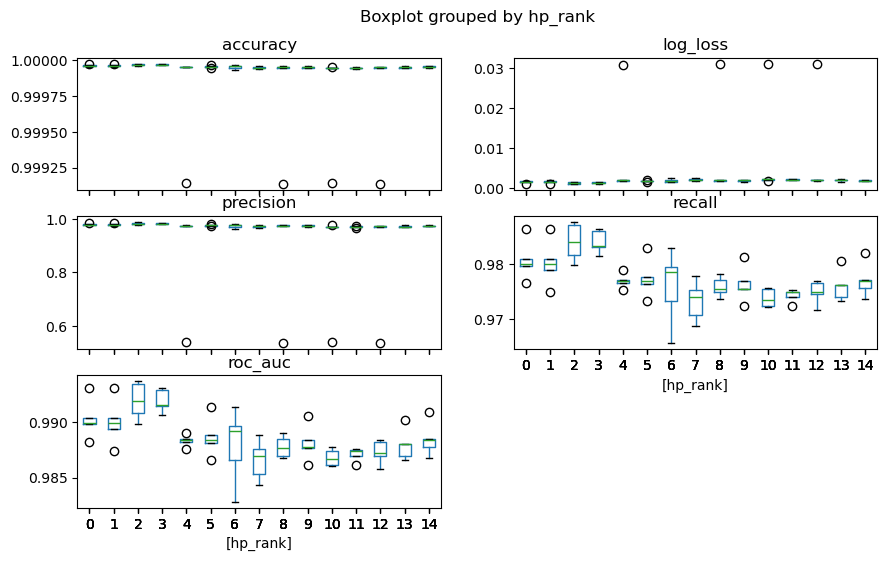

In [21]:
CollectedMetrics.drop('fold', axis=1).boxplot(by='hp_rank', sharey=False, grid=False, figsize=(10, 6))

In [22]:
CollectedMetrics.drop('fold', axis=1).melt(id_vars=['hp_rank']).groupby(['hp_rank', 'variable'])['value'].agg(['mean', 'median', 'std'])

mean    median       std
hp_rank variable                               
0       accuracy   0.999960  0.999959  0.000007
        log_loss   0.001429  0.001496  0.000265
        precision  0.979716  0.978495  0.003878
        recall     0.980632  0.980000  0.003541
        roc_auc    0.990306  0.989989  0.001772
...                     ...       ...       ...
14      accuracy   0.999951  0.999952  0.000004
        log_loss   0.001761  0.001717  0.000135
        precision  0.974138  0.973258  0.002031
        recall     0.977050  0.976923  0.003084
        roc_auc    0.988512  0.988449  0.001542

[75 rows x 3 columns]

In [23]:
CollectedMetrics.groupby('hp_rank').agg(
    mean=('log_loss', np.mean),
    ).sort_values('mean').head(5)

/var/folders/zh/p6wj0vfs3qq684w4b1m0_tvr0000gn/T/ipykernel_61982/1342183298.py:1: FutureWarning: The provided callable <function mean at 0x10581bce0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  CollectedMetrics.groupby('hp_rank').agg(


,mean
hp_rank,
3,0.001195
2,0.001197
0,0.001429
1,0.001481
5,0.001681


In [24]:
CollectedMetrics.groupby('hp_rank').agg(
    median=('log_loss', np.median),
    ).sort_values('median').head(5)

/var/folders/zh/p6wj0vfs3qq684w4b1m0_tvr0000gn/T/ipykernel_61982/1022900596.py:1: FutureWarning: The provided callable <function median at 0x10596eac0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  CollectedMetrics.groupby('hp_rank').agg(


,median
hp_rank,
3,0.001236
2,0.001246
0,0.001496
1,0.001496
6,0.001606


In [25]:
param_dict[3]

{'num_trees': 266,
 'learning_rate': 0.0105456660775919,
 'min_data_in_leaf': 42,
 'objective': 'binary',
 'early_stopping_round': -1}